# Forecasting Sales of `National Segment` with the Holt-Winters Method

In [5]:
# dataframe opertations
import pandas as pd
import numpy as np
# plotting data - matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#evaluation metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

#Ignore the warning, can comment this 
import warnings
warnings.filterwarnings("ignore")

# For graphing purpose, can change 
plt.style.use('seaborn-bright')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

pd.options.display.float_format = '{:,}'.format
pd.options.display.float_format = "{:,.2f}".format

# Uploading data and indexing by time

In [6]:
# Import the data
data = pd.read_csv("data.csv")

In [14]:
#making a copy to not change the original df 
df = data.copy()

In [17]:
df.head(2)

,Unnamed: 0,store_code,week_code,prod_code,units_sold,sales_(€),sales_volume_(lt),real_unit_price,real_volume_price,rate_price_in_units,...,brand,packaging,volume_(ml),units_(ct),province,autonomous_community,min_temp,max_temp,avg_temp,precipitation_(mm)
49,49,243,42,824,10,6.10,3,0.61,0.33,0.61,...,MAN 3 - BRAND 1,CAN,330,1,La Rioja,La Rioja,5.67,12.29,8.80,1.29
50,50,243,42,832,12,6.36,4,0.53,0.33,0.53,...,MAN 3 - BRAND 1,CAN,330,1,La Rioja,La Rioja,5.67,12.29,8.80,1.29


In [16]:
#slicing based on desired segment to forecast
df = df[df.segment == 'NATIONAL']

#making sure that we are only handling the NATIONAL segment
df['segment'].unique()

array(['NATIONAL'], dtype=object)

In [18]:
#selecting columns to work with
df = df[['date', 'sales_(€)']]
df.head()

,date,sales_(€)
49,2020-10-18,6.10
50,2020-10-18,6.36
51,2020-10-18,1.36
52,2020-10-18,13.50
53,2020-10-18,13.44


In [19]:
#checking shape of df
df.shape

(1786758, 2)

In [20]:
#date to datetime object
df['date'] = pd.to_datetime(df['date'])

#grouping by week to get total weekly sales
df = df.groupby(['date'])['sales_(€)'].sum().to_frame()

#check output
df.head()

,sales_(€)
date,
2020-01-05,"1,067,654.68"
2020-01-12,"1,054,153.51"
2020-01-19,"1,044,524.73"
2020-01-26,"1,074,834.58"
2020-02-02,"1,108,612.20"


In [21]:
#final df must have 120 weeks of data rocorded
df.shape

(120, 1)

## Visualizing the data

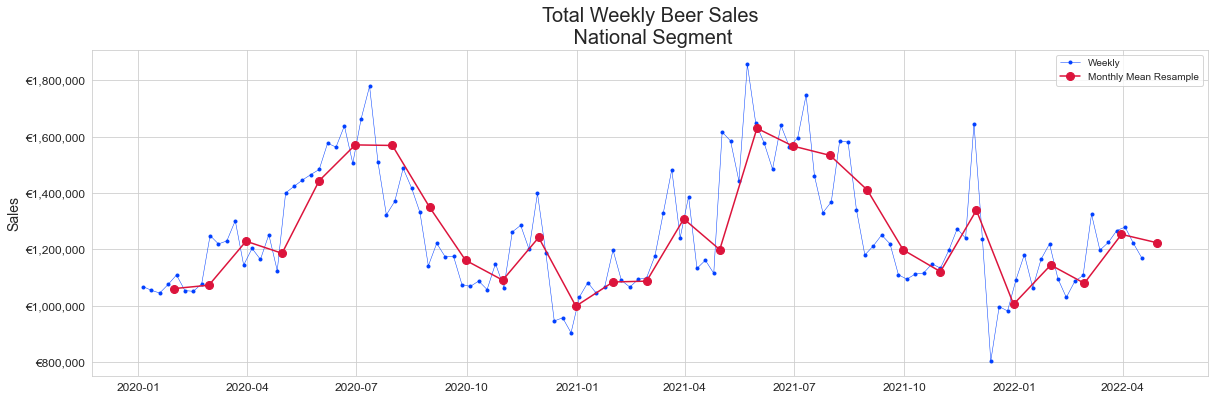

In [23]:
import seaborn as sns
sns.set_style("whitegrid")

import warnings
import matplotlib.pyplot as plt
y = df['sales_(€)']

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', 
        markersize=8, linestyle='-', 
        label='Monthly Mean Resample', 
        color='crimson')

plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.set_title("Total Weekly Beer Sales\n National Segment", fontsize=20)
ax.set_ylabel('Sales')
ax.legend();

## Decomposing the Data

In [24]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

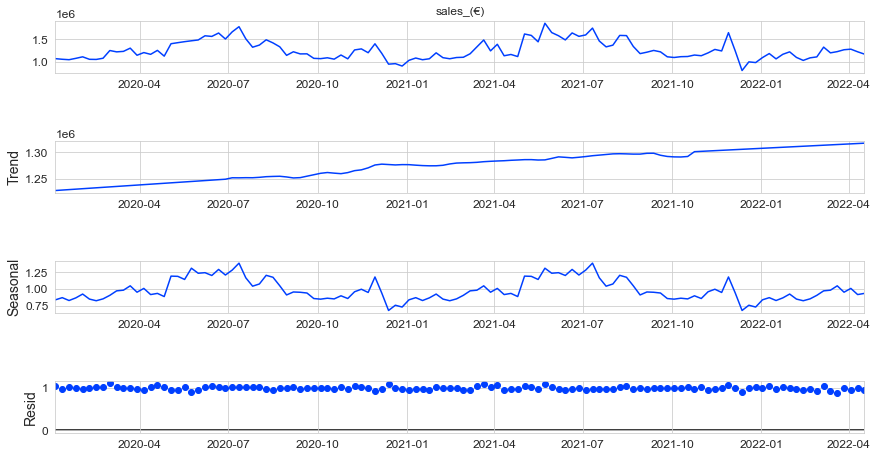

In [25]:
seasonal_decompose(y)

# Single HWES

In [28]:
# Set the frequency of the date time index as Monthly start as indicated by the data
df.index.freq = "W"

# Set the value of Alpha and define m (Time Period)
m = 52
alpha = 1/(2*m)

#fitting the model
df['HWES1'] = SimpleExpSmoothing(df['sales_(€)']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues

MAPE% on fitted values HW Single Exp Smoothing = 12.63%


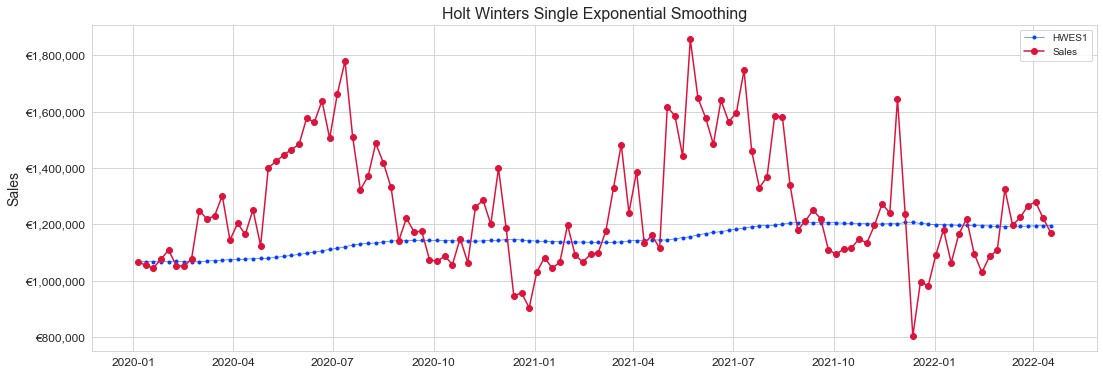

In [30]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df['HWES1'],marker='.', linestyle='-', linewidth=0.5, label='HWES1')
ax.plot(df['sales_(€)'],marker='o', markersize=6, linestyle='-', label='Sales', color='crimson')
ax.set_title(f"Holt Winters Single Exponential Smoothing", fontsize=16)
ax.set_ylabel('Sales')
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.legend();

#evaluation metric
mape_HWES1 = round(mean_absolute_percentage_error(df['sales_(€)'],df['HWES1'])*100, 2)

#printing evaluation metric
print(f'MAPE% on fitted values HW Single Exp Smoothing = {mape_HWES1}%')

## Observations
As expected, it didn’t fit quite well, and rightfully so, because if we remember, Single ES doesn’t work for data with Trends and Seasonality. 
Based on the decomposition of the data we have an upwards trend and we can also see a monthly seasonality

# Double HWES

In [31]:
df['HWES2_ADD'] = ExponentialSmoothing(df['sales_(€)'],trend='add').fit().fittedvalues

df['HWES2_MUL'] = ExponentialSmoothing(df['sales_(€)'],trend='mul').fit().fittedvalues

df[['sales_(€)','HWES2_ADD','HWES2_MUL']]

,sales_(€),HWES2_ADD,HWES2_MUL
date,,,
2020-01-05,"1,067,654.68","1,024,652.09","1,012,381.94"
2020-01-12,"1,054,153.51","1,070,487.41","1,049,986.90"
2020-01-19,"1,044,524.73","1,076,657.59","1,053,047.54"
2020-01-26,"1,074,834.58","1,071,915.46","1,047,407.08"
2020-02-02,"1,108,612.20","1,090,519.78","1,066,466.58"
...,...,...,...
2022-03-20,"1,223,954.80","1,216,378.28","1,219,462.55"
2022-03-27,"1,265,937.95","1,223,212.44","1,226,182.49"
2022-04-03,"1,278,748.39","1,253,960.51","1,257,392.20"


MAPE% for fitted values HWS2_ADD = 7.82%
MAPE% for fitted values HWS2_MUL = 7.83%


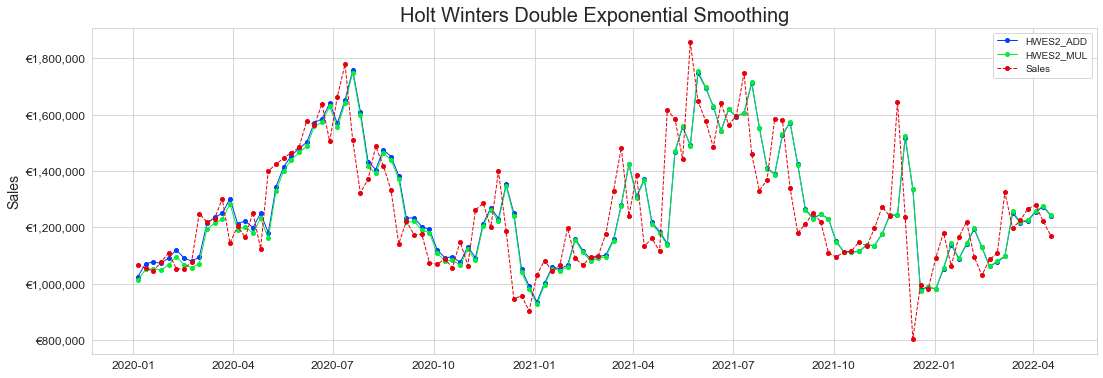

In [32]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df['HWES2_ADD'],marker='o',markersize=4, linestyle='-', linewidth=1, label='HWES2_ADD')
ax.plot(df['HWES2_MUL'],marker='o',markersize=4, linestyle='-', linewidth=1, label='HWES2_MUL')
ax.plot(df['sales_(€)'],marker='o', markersize=4, linestyle='--', linewidth=1, label='Sales')
ax.set_title("Holt Winters Double Exponential Smoothing", fontsize=20)
ax.set_ylabel('Sales')
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.legend();

#evaluation metrics
mape_HWS2_ADD = round(mean_absolute_percentage_error(df['sales_(€)'],df['HWES2_ADD'])*100, 2)
mape_HWS2_MUL = round(mean_absolute_percentage_error(df['sales_(€)'],df['HWES2_MUL'])*100, 2)

#printing evaluation metrics        
print(f'MAPE% for fitted values HWS2_ADD = {mape_HWS2_ADD}%')
print(f'MAPE% for fitted values HWS2_MUL = {mape_HWS2_MUL}%')

### Observations
Well, this looks a little better, but since we know there is Seasonality, we shall move into Triple ES and look at how it fits.

# Triple HWES

In [33]:
#Triple HWES helps us include a seasonal periods
#the seasonal parameter for out data is s=52 (the one attributed to data with weekly seasonality)

df['HWES3_ADD'] = ExponentialSmoothing(df['sales_(€)'], trend='add',seasonal='add',seasonal_periods=52).fit().fittedvalues

df['HWES3_MUL'] = ExponentialSmoothing(df['sales_(€)'], trend='mul',seasonal='mul',seasonal_periods=52).fit().fittedvalues

df[['HWES3_ADD', 'HWES3_MUL', 'sales_(€)']]

,HWES3_ADD,HWES3_MUL,sales_(€)
date,,,
2020-01-05,"1,000,742.27","1,006,703.39","1,067,654.68"
2020-01-12,"1,055,694.99","1,057,899.34","1,054,153.51"
2020-01-19,"1,018,784.13","1,021,677.02","1,044,524.73"
2020-01-26,"1,041,788.40","1,043,202.33","1,074,834.58"
2020-02-02,"1,175,144.47","1,172,665.51","1,108,612.20"
...,...,...,...
2022-03-20,"1,478,203.61","1,462,405.45","1,223,954.80"
2022-03-27,"1,236,128.32","1,229,284.02","1,265,937.95"
2022-04-03,"1,373,270.05","1,364,815.16","1,278,748.39"


MAPE% for fitted values HWS3_ADD = 3.65%
MAPE% for ftted values HWS3_MUL = 3.59%


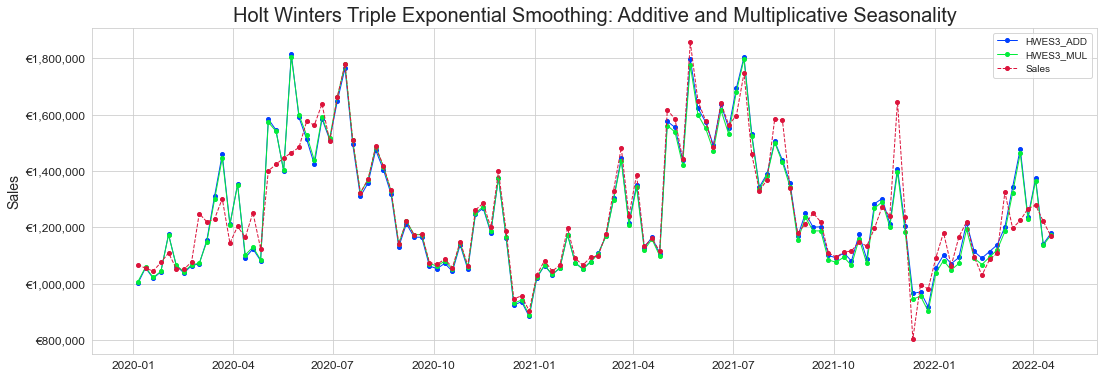

In [34]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df['HWES3_ADD'],marker='o',markersize=4, linestyle='-', linewidth=1, label='HWES3_ADD')
ax.plot(df['HWES3_MUL'],marker='o',markersize=4, linestyle='-', linewidth=1, label='HWES3_MUL')
ax.plot(df['sales_(€)'],marker='o', markersize=4, linestyle='--', linewidth=1, label='Sales', color='crimson')
ax.set_title("Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality", fontsize=20)
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.set_ylabel('Sales')

ax.legend();

#evaluation metrics
mape_HWS3_ADD = round(mean_absolute_percentage_error(df['sales_(€)'],df['HWES3_ADD'])*100, 2)
mape_HWS3_MUL = round(mean_absolute_percentage_error(df['sales_(€)'],df['HWES3_MUL'])*100, 2)

#printing evaluation metrics        
print(f'MAPE% for fitted values HWS3_ADD = {mape_HWS3_ADD}%')
print(f'MAPE% for ftted values HWS3_MUL = {mape_HWS3_MUL}%')

# Splitting into Train & Test Set
Why are we sticking with HW Triple Exponential Smoothing?
Because according to the diagnostic plots made in the beginning we know there is Seasonality and a Trend and the MAPE% on fitted values for the `HW Triple ES` indicate the lowest proprotion of error, therefore, this model is the best option for us. 

In [36]:
forecast_data = data.copy() #making a copy of the original df

In [37]:
#slicing based on desired segment to forecast
forecast_data = forecast_data[forecast_data.segment == 'NATIONAL']

#making sure that we are only handling the NATIONAL segment
forecast_data['segment'].unique()

array(['NATIONAL'], dtype=object)

In [38]:
#converting to datetime index
forecast_data['date'] = pd.to_datetime(forecast_data['date'])

#groping by weekly total sales
forecast_data = forecast_data.groupby(['date'])['sales_(€)'].sum().to_frame()

In [39]:
#checking output
forecast_data.head()

,sales_(€)
date,
2020-01-05,"1,067,654.68"
2020-01-12,"1,054,153.51"
2020-01-19,"1,044,524.73"
2020-01-26,"1,074,834.58"
2020-02-02,"1,108,612.20"


In [40]:
#final df must have 120 rows of recorded data
forecast_data.shape

(120, 1)

In [41]:
#Let's split our data with the traditional 80/20 split
#Since we are dealing with time series data the order to the records must be kept intact

train = forecast_data[:105]  # taking 96 data points as train-set
test = forecast_data[105:] # taking the last 24 data points as test-set 

In [42]:
#checking dates for train-set
print(train.index.min())
print(train.index.max())

2020-01-05 00:00:00
2022-01-02 00:00:00


In [43]:
#checking dates for test-set
print(test.index.min())
print(test.index.max())

2022-01-09 00:00:00
2022-04-17 00:00:00


In [44]:
#shapes must be 105 and 15 respectively
print(train.shape)
print(test.shape)

(105, 1)
(15, 1)


# Fitting the Models to the train data & making forecasts

In [48]:
#creating an empty container to score model evaluation metrics
model_metrics = []

In [49]:
#defining a function to change parameters easily and do a trial and error procedure
def HW_model(trend, seasonal, seasonal_periods, damped, title):
    
    fitted_model = ExponentialSmoothing(train['sales_(€)'],
                                    trend=trend,
                                    seasonal=seasonal,
                                    seasonal_periods=seasonal_periods,
                                    use_boxcox=True,
                                    damped=damped, 
                                    initialization_method="estimated").fit()

    test_predictions = fitted_model.forecast(15) 
    title=title
    
    #plotting
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(train['sales_(€)'],marker='o',markersize=4, linestyle='-', linewidth=1, label='Train')
    ax.plot(test['sales_(€)'],marker='o',markersize=4, linestyle='-', linewidth=1, label='Test', color='limegreen')
    ax.plot(test_predictions, marker='o', markersize=4, linestyle='-', linewidth=1, label='Prediction', color='crimson')
    ax.set_title(f'{title}\nTrain, Test and Predicted Values\n Holt-Winters ({trend}-{seasonal}-seasonal-damped={damped})', fontsize=16)
    ax.set_ylabel('Sales')
    plt.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}'))  
    plt.show()
    ax.legend();

    #zooming into test vs predicted
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(test['sales_(€)'], marker='o', markersize=5, linestyle='-', linewidth=1, label='Test', color='limegreen')
    ax.plot(test_predictions, marker='o', markersize=5, linestyle='-', linewidth=1, label='Prediction', color='crimson')
    ax.set_title('Zooming in', fontsize=16)
    ax.set_ylabel('Sales')
    plt.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}'))  
    ax.legend();
    plt.show()

    #saving metrics in variables
    mae = mean_absolute_error(test,test_predictions)
    mse = mean_squared_error(test,test_predictions)
    mape = round(mean_absolute_percentage_error(test,test_predictions)*100, 2)
    rmse = mean_squared_error(test,test_predictions, squared=False)
    
    #printing evaluation metrics        
    print(f'Mean Absolute Error = {mae}')
    print(f'Mean Squared Error = {mse}')
    print(f'MAPE% = {mape}%')
    print(f'RMSE = {rmse}')

    #saving metrics for later comparison
    model_metrics.append({
            "model" : f'HW ({trend}-{seasonal}-seasonal-damped={damped})',
            "MAE" : mae,
            "MSE": mse, 
            "MAPE": f'{mape}%', 
            "RMSE": f'{rmse}'
    })

## Holt-Winters (add-add-seasonal)

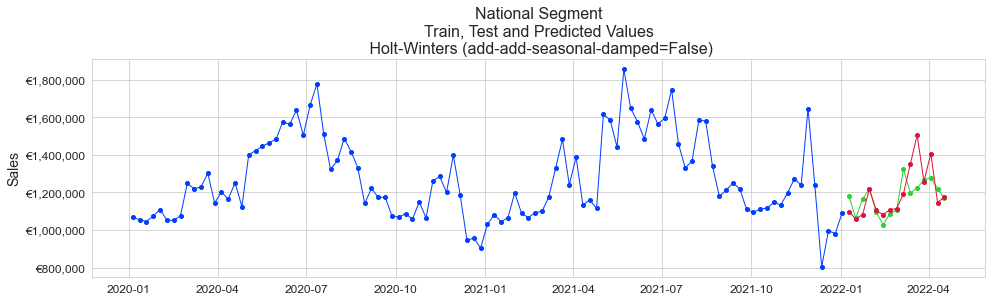

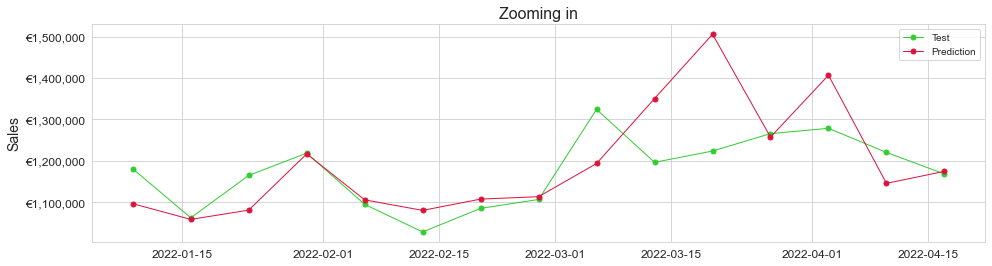

Mean Absolute Error = 69925.50296233899
Mean Squared Error = 10634554528.26494
MAPE% = 5.77%
RMSE = 103123.97649559942


In [50]:
HW_model('add', 'add', 52, False, "National Segment")

## Holt-Winters (add-add-seasonal-damped)

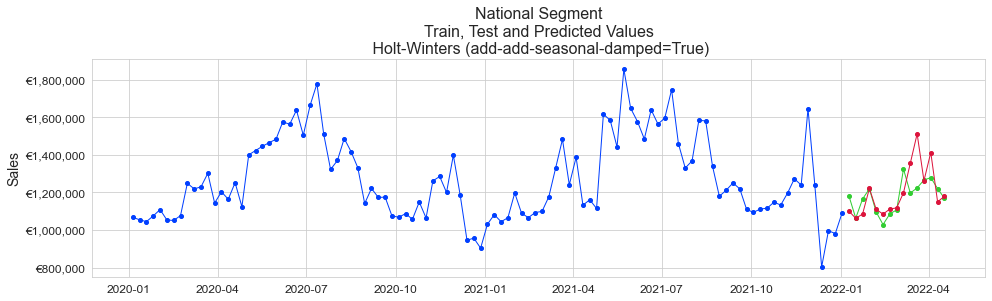

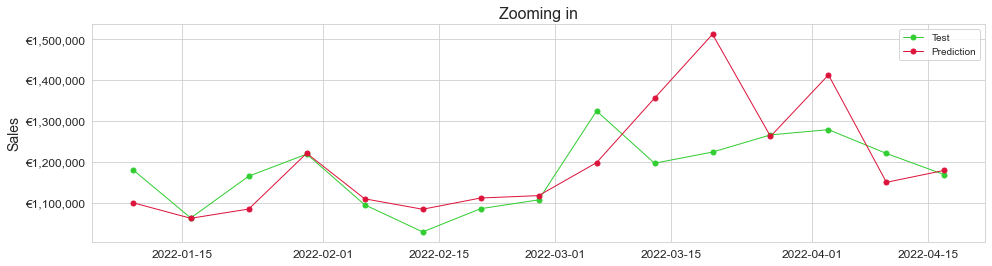

Mean Absolute Error = 70801.83895926518
Mean Squared Error = 10941743535.86162
MAPE% = 5.85%
RMSE = 104602.78933117233


In [51]:
HW_model('add', 'add', 52, True, 'National Segment')

## Holt-Winters (add-mul-seasonal)

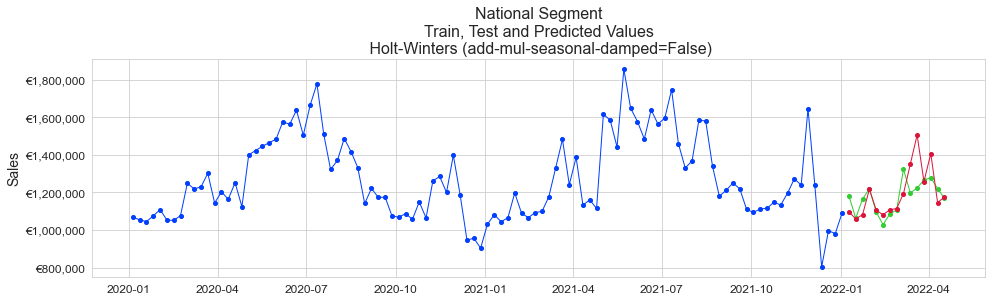

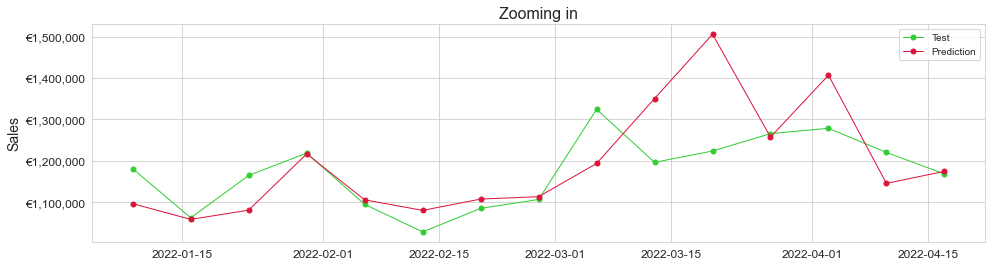

Mean Absolute Error = 69926.43013826106
Mean Squared Error = 10634955147.830217
MAPE% = 5.77%
RMSE = 103125.91889447685


In [52]:
HW_model('add', 'mul', 52, False, 'National Segment')

## Holt-Winters (add-mul-seasonal-damped)

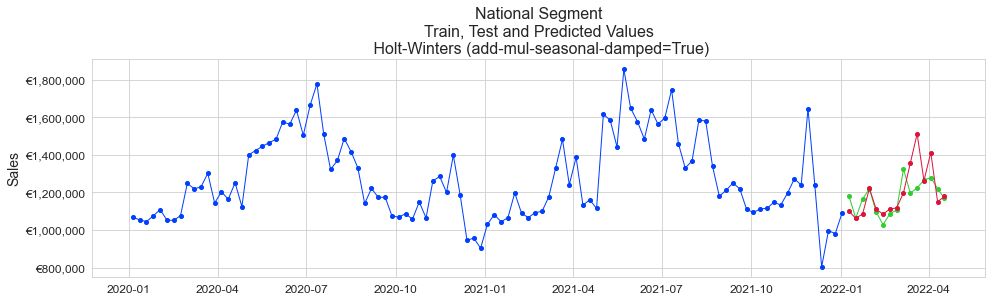

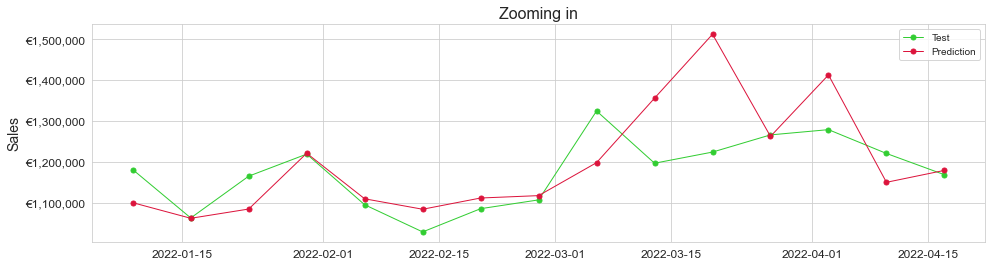

Mean Absolute Error = 70801.91020196762
Mean Squared Error = 10941784468.526659
MAPE% = 5.85%
RMSE = 104602.98498860661


In [53]:
HW_model('add', 'mul', 52, True, "National Segment")

# Model Comparison

In [54]:
model_metrics
model_metrics_df = pd.DataFrame(model_metrics, 
                                columns = ["model", 
                                           'MSE',
                                           'MAE', 
                                           "MAPE", 
                                           "RMSE"]).set_index("model").sort_values(by=["MAPE"], ascending = True)
model_metrics_df  

,MSE,MAE,MAPE,RMSE
model,,,,
HW (add-add-seasonal-damped=False),"10,634,554,528.26","69,925.50",5.77%,103123.97649559942
HW (add-mul-seasonal-damped=False),"10,634,955,147.83","69,926.43",5.77%,103125.91889447685
HW (add-add-seasonal-damped=True),"10,941,743,535.86","70,801.84",5.85%,104602.78933117233
HW (add-mul-seasonal-damped=True),"10,941,784,468.53","70,801.91",5.85%,104602.98498860661


## The metric to that is going to decide the overall performance of the model is the MAPE%, this is how it should be interpreted:
* A `MAPE%` of `4.91%` implies the model is `95.09%` accurate in predicting the next 15 observations 

# Forecasting

In [56]:
#defining a function to make forecasts in any range of steps ahead
def final_HW_model(trend, seasonal, seasonal_periods, damped, steps_ahead, title):
    
    #defining variables to describe parameters and specifics of the model and timeframes
    trend = trend
    seasonal = seasonal
    seasonal_periods = seasonal_periods
    damped = damped
    
    #fitting the model
    fit = ExponentialSmoothing(forecast_data,
                            trend=trend,
                            seasonal=seasonal,
                            seasonal_periods=seasonal_periods, 
                            damped=damped,
                            use_boxcox=True, 
                            initialization_method="estimated").fit()
    
    simulations = fit.simulate(steps_ahead, repetitions=100, error="add")
    
    ax = forecast_data.plot(figsize=(18, 6), marker="o", markersize=4, lw=1)
    ax.set_title(f"Forecast and Simulation for {title}\nHolt-Winters ({trend}-{seasonal}-seasonal-damped={damped})\n Forecast for FY-2023", fontsize=18)
    ax.set_ylabel("Sales")
    ax.set_xlabel(" ")
    plt.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}'))

    fit.fittedvalues.plot(ax=ax, style="--", markersize=3, color="crimson", label='Fitted Values')
    simulations.plot(ax=ax, style="-", alpha=0.05, color="orange", legend=False)
    fit.forecast(steps_ahead).rename(f"Train, Test and Predicted Test\nHolt-Winters ({trend}-{seasonal}-seasonal-damped={damped})").plot(
    ax=ax, style="-", marker="o", markersize=4,  color="crimson", lw=1, legend=True, label='Fitted Values')
    
    return plt.show()

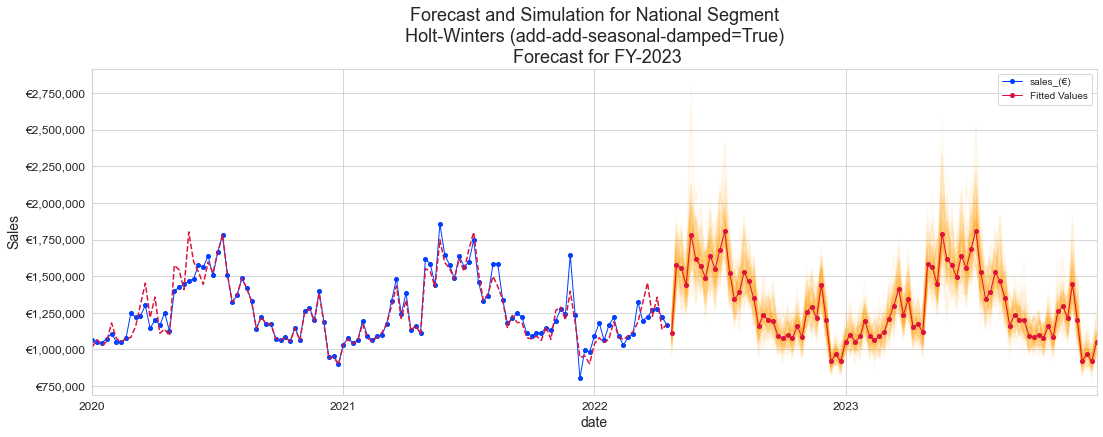

In [57]:
#why are we chooing 89 steps ahead?
    #because those the total steps ahead necessaty to do the forecast until the end of FY-2023
final_HW_model('add', 'add', 52, True, 89, 'National Segment') 

In [58]:
#defining a function to make forecasts in any range of steps ahead
def forecast_euro_value_until_2023(trend, seasonal, seasonal_periods, damped, title):
    
    #defining variables to describe parameters and specifics of the model and timeframes
    trend = trend
    seasonal = seasonal
    seasonal_periods = seasonal_periods
    damped = damped
    title = title
    
    #fitting the model
    fit = ExponentialSmoothing(forecast_data,
                            trend=trend,
                            seasonal=seasonal,
                            seasonal_periods=seasonal_periods, 
                            damped=damped,
                            use_boxcox=True, 
                            initialization_method="estimated").fit()


    #making the forecast and putting values in inside a dataframe
    forecast = fit.forecast(89).to_frame().reset_index()

    #rename columns for more readability
    forecast.rename(columns={0: title, 'index': 'date'} ,inplace=True)

    #convert date column to datetime object
    forecast['date'] = pd.to_datetime(forecast['date'])

    #group by quarterly total sales
    return print(forecast.groupby(forecast['date'].dt.to_period('Q'))[title].sum().to_frame()), print(forecast.groupby(forecast['date'].dt.to_period('Y'))[title].sum().to_frame())

In [60]:
#defining a function to input the parameters of the best model and getting predictions in euro value
forecast_euro_value_until_2023('add', 'add', 52, True, "national_segment_sales")

        national_segment_sales
date                          
2022Q2           15,331,157.81
2022Q3           17,961,072.26
2022Q4           14,708,260.52
2023Q1           15,008,187.33
2023Q2           19,044,600.10
2023Q3           18,000,248.76
2023Q4           15,783,393.93
      national_segment_sales
date                        
2022           48,000,490.60
2023           67,836,430.12


(None, None)